## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [2]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [3]:
# (re-)load layers
%run modules.ipynb

<>:3: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2367876760.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

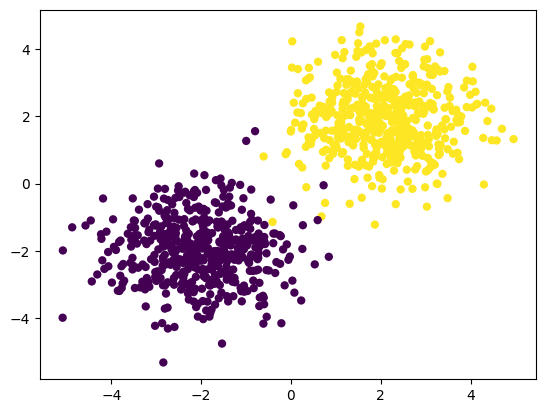

In [12]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [10]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

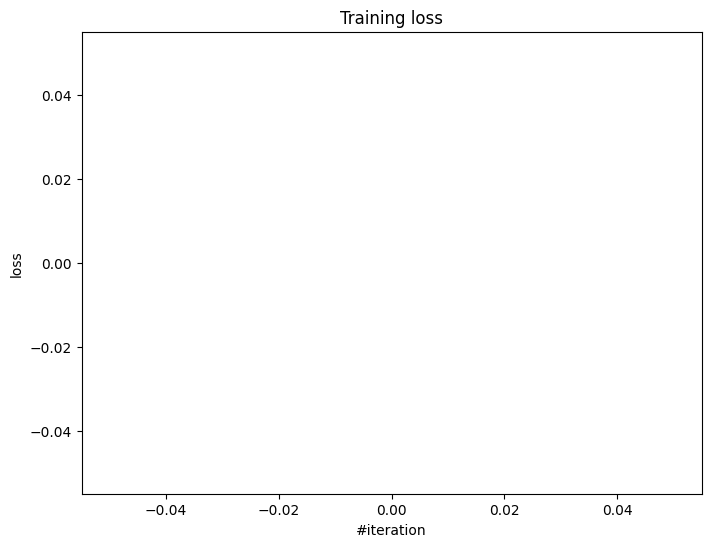

Current loss: %f None


In [14]:


loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f',loss)



# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
#!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc



File ‘mnist.py’ already there; not retrieving.



In [26]:
from datasets import load_dataset
dataset = load_dataset("ylecun/mnist")

X_train_val = np.array(dataset['train']['image'])
y_train_val = np.array(dataset['train']['label'])
X_test = np.array(dataset['test']['image'])
y_test = np.array(dataset['test']['label'])

# Разделение тренировочных данных на train и validation (стандартное 50k/10k)
# Общие тренировочные данные содержат 60000 примеров
X_train = X_train_val[:50000]
y_train = y_train_val[:50000]
X_val = X_train_val[50000:]
y_val = y_train_val[50000:]


In [16]:
X_train_val = np.array(dataset['train']['image'])
y_train_val = np.array(dataset['train']['label'])
X_test = np.array(dataset['test']['image'])
y_test = np.array(dataset['test']['label'])

# Разделение тренировочных данных на train и validation (стандартное 50k/10k)
# Общие тренировочные данные содержат 60000 примеров
X_train = X_train_val[:50000]
y_train = y_train_val[:50000]
X_val = X_train_val[50000:]
y_val = y_train_val[50000:]


One-hot encode the labels first.

In [17]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_val_onehot = one_hot_encode(y_train_val)
y_test_onehot = one_hot_encode(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
relu = Sequential()
relu.add(Flatten())
relu.add(Linear(784, 100))
relu.add(ReLU())
relu.add(Linear(100, 10))
relu.add(LogSoftMax())
print("ReLU activation function:\n", relu)

 ReLU activation function:
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [ ]:
elu = Sequential()
elu.add(Flatten())
elu.add(Linear(784, 100))
elu.add(ELU(alpha=1))
elu.add(Linear(100, 10))
elu.add(LogSoftMax())
print("ELU activation function:\n", elu)

ELU activation function:
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [ ]:
leaky_relu = Sequential()
leaky_relu.add(Flatten())
leaky_relu.add(Linear(784, 100))
leaky_relu.add(LeakyReLU())
leaky_relu.add(Linear(100, 10))
leaky_relu.add(LogSoftMax())
print("LeakyReLU activation function:\n", leaky_relu)

LeakyReLU activation function:
 Flatten
Linear 784 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax



In [ ]:

# SoftPlus модель (аналогично ELU)
softplus = Sequential()
softplus.add(Flatten())
softplus.add(Linear(784, 100))
softplus.add(SoftPlus())  # Обычно SoftPlus без параметров
softplus.add(Linear(100, 10))
softplus.add(LogSoftMax())
print("\nSoftPlus activation function:\n", softplus)


SoftPlus activation function:
 Flatten
Linear 784 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax



**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Print here your accuracy on test set. It should be around 90%.

Data ready!
Train: (50000, 784), Val: (10000, 784), Test: (10000, 784)

COMPARISON: Simple vs Complex Models
Training on 10000 samples
Validating on 2000 samples
Testing on 2000 samples

Training models...

RELU: Training simple model...
RELU: Training complex model...
  Simple: 0.1170, Complex: 0.8770

ELU: Training simple model...
ELU: Training complex model...
  Simple: 0.1170, Complex: 0.8880

LEAKY: Training simple model...
LEAKY: Training complex model...
  Simple: 0.1170, Complex: 0.8920

SOFTPLUS: Training simple model...
SOFTPLUS: Training complex model...
  Simple: 0.0890, Complex: 0.8015


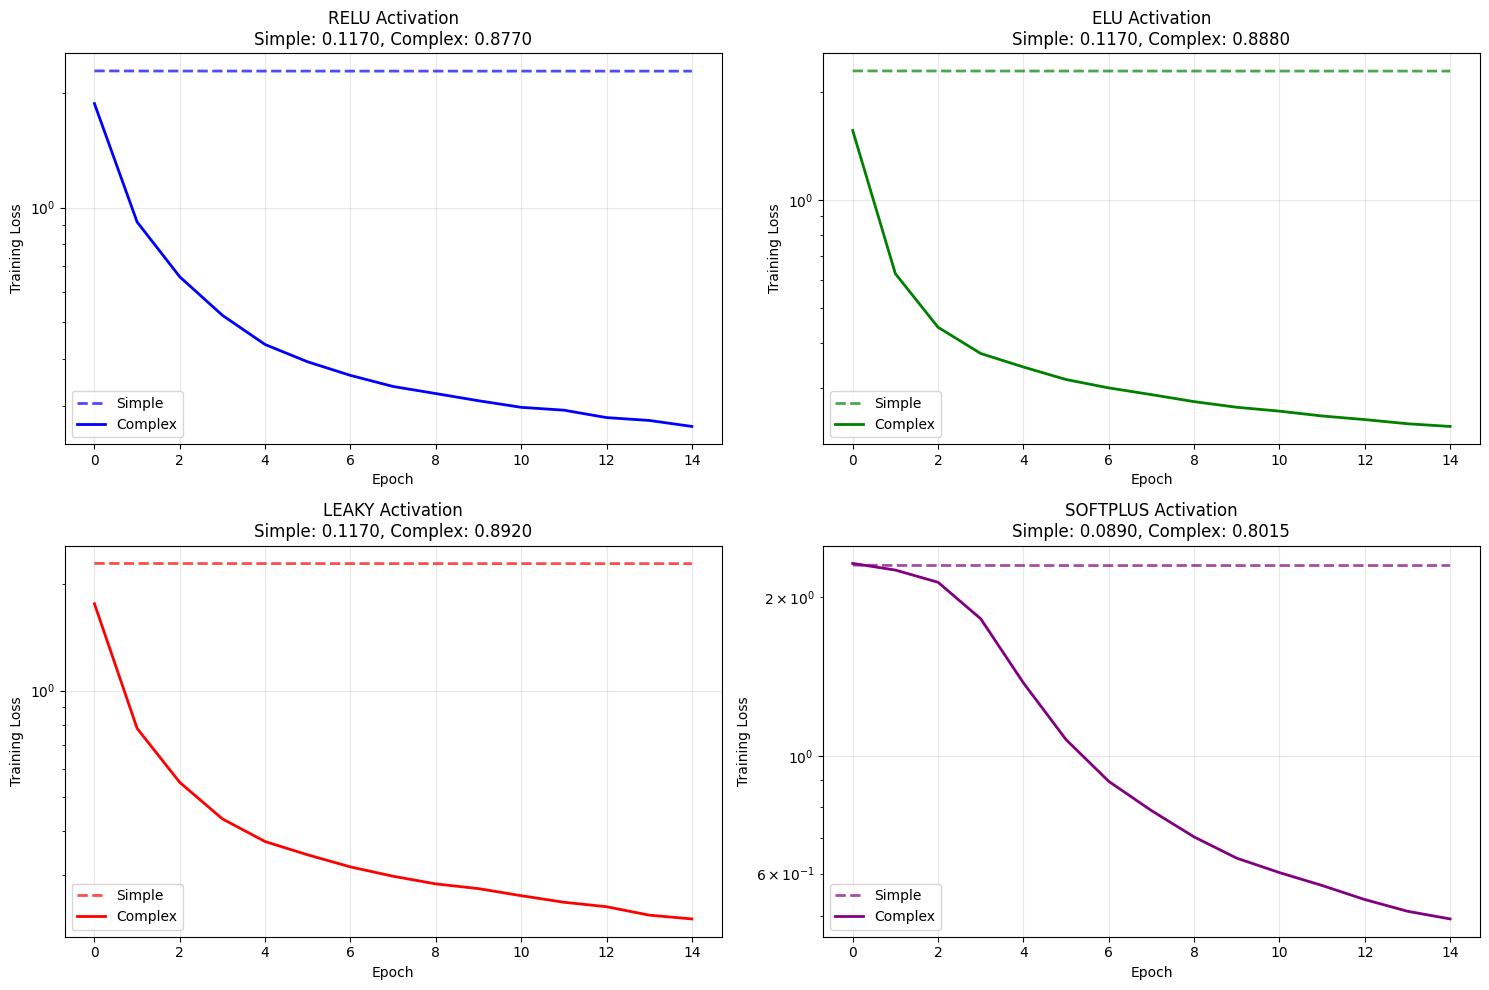

/tmp/ipython-input-3117647798.py:446: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


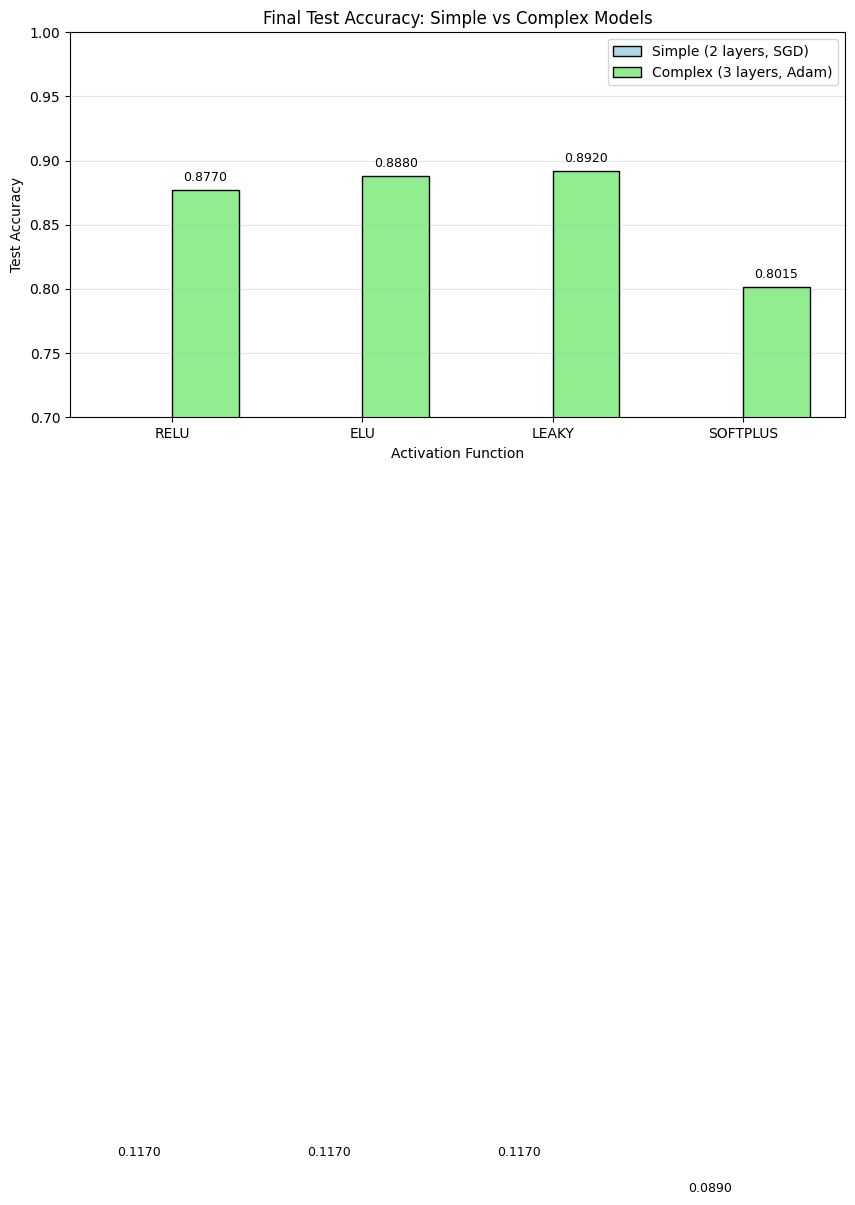


BEST MODELS SUMMARY

Best Simple Model: RELU (Accuracy: 0.1170)
Best Complex Model: LEAKY (Accuracy: 0.8920)

Improvement: +0.7750

SAMPLE PREDICTIONS (Best Complex Model)

Retrained Best Complex Model (LEAKY):
Final Test Accuracy: 0.8935


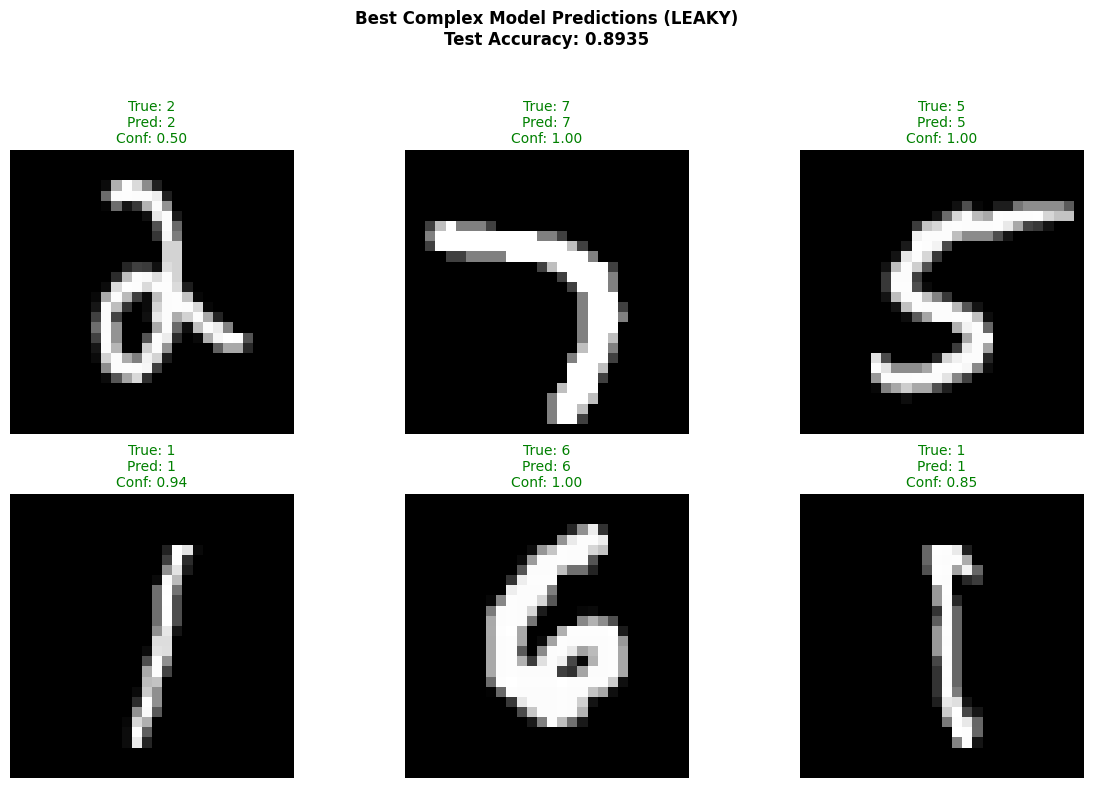

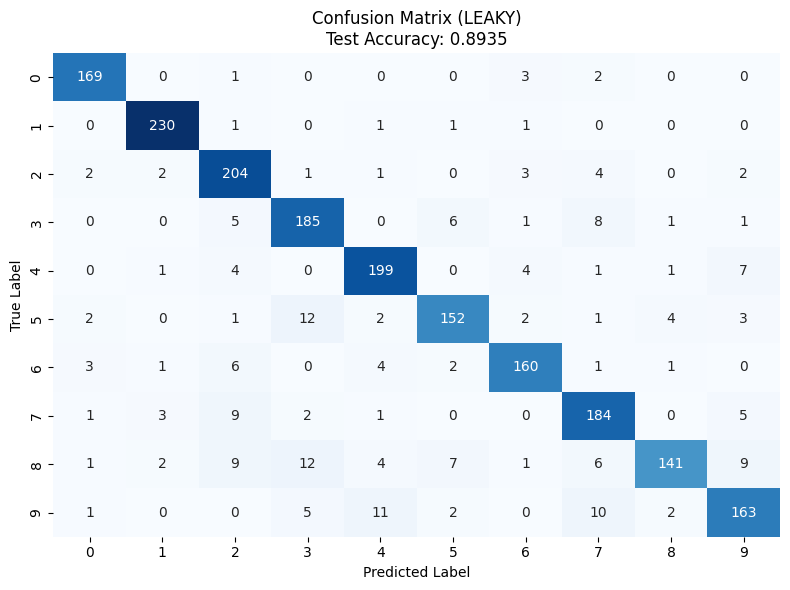


Classification Report:
              precision    recall  f1-score   support

           0      0.944     0.966     0.955       175
           1      0.962     0.983     0.973       234
           2      0.850     0.932     0.889       219
           3      0.853     0.894     0.873       207
           4      0.892     0.917     0.905       217
           5      0.894     0.849     0.871       179
           6      0.914     0.899     0.907       178
           7      0.848     0.898     0.872       205
           8      0.940     0.734     0.825       192
           9      0.858     0.840     0.849       194

    accuracy                          0.893      2000
   macro avg      0.896     0.891     0.892      2000
weighted avg      0.895     0.893     0.893      2000


EXPERIMENT COMPLETE


In [39]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



# Предобработка
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_val = X_val.reshape(-1, 784).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255.0


print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ============================================================================
# ОБЩИЕ ФУНКЦИИ
# ============================================================================

def to_onehot(y, num_classes=10):
    """Преобразование в one-hot encoding"""
    onehot = np.zeros((len(y), num_classes), dtype=np.float32)
    onehot[np.arange(len(y)), y] = 1.0
    return onehot

def softmax(x):
    """Стабильный softmax"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# ============================================================================
# ПРОСТАЯ МОДЕЛЬ (2 слоя)
# ============================================================================

class SimpleModel:
    def __init__(self, activation_type='relu', hidden_size=128):
        self.activation_type = activation_type

        # Инициализация весов
        self.W1 = np.random.randn(784, hidden_size).astype(np.float32) * 0.1
        self.b1 = np.zeros(hidden_size, dtype=np.float32)
        self.W2 = np.random.randn(hidden_size, 10).astype(np.float32) * 0.1
        self.b2 = np.zeros(10, dtype=np.float32)

        # Кэш
        self.z1 = None
        self.a1 = None

    def activation(self, x):

        if self.activation_type == 'relu':
            return np.maximum(0, x)
        elif self.activation_type == 'elu':
            return np.where(x > 0, x, 1.0 * (np.exp(x) - 1))
        elif self.activation_type == 'leaky':
            return np.where(x > 0, x, 0.01 * x)
        elif self.activation_type == 'softplus':
            return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
        return np.maximum(0, x)

    def activation_derivative(self, x):
        """Производная функции активации"""
        if self.activation_type == 'relu':
            return (x > 0).astype(np.float32)
        elif self.activation_type == 'elu':
            return np.where(x > 0, 1, 1.0 * np.exp(x))
        elif self.activation_type == 'leaky':
            return np.where(x > 0, 1, 0.01)
        elif self.activation_type == 'softplus':
            sigmoid = 1 / (1 + np.exp(-x))
            return sigmoid
        return (x > 0).astype(np.float32)

    def forward(self, X):
        # Скрытый слой
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.activation(self.z1)

        # Выходной слой
        z2 = self.a1 @ self.W2 + self.b2
        output = softmax(z2)

        return output

    def backward(self, X, y, output, lr=0.01):
        m = X.shape[0]

        # Градиент выходного слоя
        dz2 = output - y

        # Градиенты для W2, b2
        dw2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0) / m

        # Градиент скрытого слоя
        dz1 = (dz2 @ self.W2.T) * self.activation_derivative(self.z1)

        # Градиенты для W1, b1
        dw1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0) / m

        # Обновление весов
        self.W1 -= lr * dw1
        self.b1 -= lr * db1
        self.W2 -= lr * dw2
        self.b2 -= lr * db2

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

# ============================================================================
# СЛОЖНАЯ МОДЕЛЬ (3 слоя)
# ============================================================================

class ComplexModel:
    def __init__(self, activation_type='relu'):
        self.activation_type = activation_type

        # Инициализация весов
        self.W1 = np.random.randn(784, 256).astype(np.float32) * np.sqrt(2.0/784)
        self.b1 = np.zeros(256, dtype=np.float32)

        self.W2 = np.random.randn(256, 128).astype(np.float32) * np.sqrt(2.0/256)
        self.b2 = np.zeros(128, dtype=np.float32)

        self.W3 = np.random.randn(128, 10).astype(np.float32) * np.sqrt(2.0/128)
        self.b3 = np.zeros(10, dtype=np.float32)

        # Кэш
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

        # Adam оптимизатор
        self.m_W1 = np.zeros_like(self.W1)
        self.v_W1 = np.zeros_like(self.W1)
        self.m_b1 = np.zeros_like(self.b1)
        self.v_b1 = np.zeros_like(self.b1)

        self.m_W2 = np.zeros_like(self.W2)
        self.v_W2 = np.zeros_like(self.W2)
        self.m_b2 = np.zeros_like(self.b2)
        self.v_b2 = np.zeros_like(self.b2)

        self.m_W3 = np.zeros_like(self.W3)
        self.v_W3 = np.zeros_like(self.W3)
        self.m_b3 = np.zeros_like(self.b3)
        self.v_b3 = np.zeros_like(self.b3)

        self.t = 0

    def activation(self, x):
        """Применение функции активации"""
        if self.activation_type == 'relu':
            return np.maximum(0, x)
        elif self.activation_type == 'elu':
            return np.where(x > 0, x, 1.0 * (np.exp(x) - 1))
        elif self.activation_type == 'leaky':
            return np.where(x > 0, x, 0.01 * x)
        elif self.activation_type == 'softplus':
            return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
        return np.maximum(0, x)

    def activation_derivative(self, x):
        """Производная функции активации"""
        if self.activation_type == 'relu':
            return (x > 0).astype(np.float32)
        elif self.activation_type == 'elu':
            return np.where(x > 0, 1, 1.0 * np.exp(x))
        elif self.activation_type == 'leaky':
            return np.where(x > 0, 1, 0.01)
        elif self.activation_type == 'softplus':
            sigmoid = 1 / (1 + np.exp(-x))
            return sigmoid
        return (x > 0).astype(np.float32)

    def forward(self, X):
        # Слой 1
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.activation(self.z1)

        # Слой 2
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.activation(self.z2)

        # Выходной слой
        z3 = self.a2 @ self.W3 + self.b3
        output = softmax(z3)

        return output

    def backward(self, X, y, output, lr=0.001):
        m = X.shape[0]
        self.t += 1

        # Градиент выходного слоя
        dz3 = output - y

        # Градиенты для слоя 3
        dW3 = (self.a2.T @ dz3) / m
        db3 = np.sum(dz3, axis=0) / m

        # Градиент для слоя 2
        dz2 = (dz3 @ self.W3.T) * self.activation_derivative(self.z2)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0) / m

        # Градиент для слоя 1
        dz1 = (dz2 @ self.W2.T) * self.activation_derivative(self.z1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0) / m

        # Adam оптимизатор для всех параметров
        beta1, beta2, eps = 0.9, 0.999, 1e-8

        # Обновление параметров слоя 1
        self.m_W1 = beta1 * self.m_W1 + (1 - beta1) * dW1
        self.v_W1 = beta2 * self.v_W1 + (1 - beta2) * (dW1 ** 2)
        m_hat_W1 = self.m_W1 / (1 - beta1 ** self.t)
        v_hat_W1 = self.v_W1 / (1 - beta2 ** self.t)
        self.W1 -= lr * m_hat_W1 / (np.sqrt(v_hat_W1) + eps)

        self.m_b1 = beta1 * self.m_b1 + (1 - beta1) * db1
        self.v_b1 = beta2 * self.v_b1 + (1 - beta2) * (db1 ** 2)
        m_hat_b1 = self.m_b1 / (1 - beta1 ** self.t)
        v_hat_b1 = self.v_b1 / (1 - beta2 ** self.t)
        self.b1 -= lr * m_hat_b1 / (np.sqrt(v_hat_b1) + eps)

        # Обновление параметров слоя 2
        self.m_W2 = beta1 * self.m_W2 + (1 - beta1) * dW2
        self.v_W2 = beta2 * self.v_W2 + (1 - beta2) * (dW2 ** 2)
        m_hat_W2 = self.m_W2 / (1 - beta1 ** self.t)
        v_hat_W2 = self.v_W2 / (1 - beta2 ** self.t)
        self.W2 -= lr * m_hat_W2 / (np.sqrt(v_hat_W2) + eps)

        self.m_b2 = beta1 * self.m_b2 + (1 - beta1) * db2
        self.v_b2 = beta2 * self.v_b2 + (1 - beta2) * (db2 ** 2)
        m_hat_b2 = self.m_b2 / (1 - beta1 ** self.t)
        v_hat_b2 = self.v_b2 / (1 - beta2 ** self.t)
        self.b2 -= lr * m_hat_b2 / (np.sqrt(v_hat_b2) + eps)

        # Обновление параметров слоя 3
        self.m_W3 = beta1 * self.m_W3 + (1 - beta1) * dW3
        self.v_W3 = beta2 * self.v_W3 + (1 - beta2) * (dW3 ** 2)
        m_hat_W3 = self.m_W3 / (1 - beta1 ** self.t)
        v_hat_W3 = self.v_W3 / (1 - beta2 ** self.t)
        self.W3 -= lr * m_hat_W3 / (np.sqrt(v_hat_W3) + eps)

        self.m_b3 = beta1 * self.m_b3 + (1 - beta1) * db3
        self.v_b3 = beta2 * self.v_b3 + (1 - beta2) * (db3 ** 2)
        m_hat_b3 = self.m_b3 / (1 - beta1 ** self.t)
        v_hat_b3 = self.v_b3 / (1 - beta2 ** self.t)
        self.b3 -= lr * m_hat_b3 / (np.sqrt(v_hat_b3) + eps)

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

# ============================================================================
# ФУНКЦИЯ ОБУЧЕНИЯ
# ============================================================================

def train_model(model, X_train, y_train, X_val, y_val,
                epochs=20, batch_size=128, lr=0.01,
                model_type='simple'):

    y_train_onehot = to_onehot(y_train)
    y_val_onehot = to_onehot(y_val)

    n_samples = len(X_train)
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Перемешивание
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train_onehot[indices]

        epoch_loss = 0
        batch_count = 0

        # Обучение по батчам
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]


            output = model.forward(X_batch)

            # В потери
            loss = -np.sum(y_batch * np.log(output + 1e-8)) / batch_size
            epoch_loss += loss
            batch_count += 1

            # Backward pass
            if model_type == 'simple':
                model.backward(X_batch, y_batch, output, lr=lr)
            else:
                model.backward(X_batch, y_batch, output, lr=lr)

        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)

        val_acc = model.accuracy(X_val, y_val)
        val_accuracies.append(val_acc)

    return train_losses, val_accuracies

# ============================================================================
# ОСНОВНОЙ КОД
# ============================================================================

print("\n" + "="*60)
print("COMPARISON: Simple vs Complex Models")
print("="*60)

# Подмножество для быстрого тестирования
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]
X_val_small = X_val[:2000]
y_val_small = y_val[:2000]
X_test_small = X_test[:2000]
y_test_small = y_test[:2000]

print(f"Training on {len(X_train_small)} samples")
print(f"Validating on {len(X_val_small)} samples")
print(f"Testing on {len(X_test_small)} samples")

# Сравниваемые функции активации
activations = ['relu', 'elu', 'leaky', 'softplus']
colors = {'relu': 'blue', 'elu': 'green', 'leaky': 'red', 'softplus': 'purple'}

# Результаты
simple_results = {}
complex_results = {}

# Обучение моделей
print("\nTraining models...")

for act in activations:
    # Простая модель
    print(f"\n{act.upper()}: Training simple model...")
    simple_model = SimpleModel(activation_type=act, hidden_size=128)
    simple_losses, simple_accs = train_model(
        simple_model, X_train_small, y_train_small, X_val_small, y_val_small,
        epochs=15, batch_size=64, lr=0.01, model_type='simple'
    )
    simple_test_acc = simple_model.accuracy(X_test_small, y_test_small)
    simple_results[act] = {'losses': simple_losses, 'accs': simple_accs, 'test_acc': simple_test_acc}

    # Сложная модель
    print(f"{act.upper()}: Training complex model...")
    complex_model = ComplexModel(activation_type=act)
    complex_losses, complex_accs = train_model(
        complex_model, X_train_small, y_train_small, X_val_small, y_val_small,
        epochs=15, batch_size=64, lr=0.001, model_type='complex'
    )
    complex_test_acc = complex_model.accuracy(X_test_small, y_test_small)
    complex_results[act] = {'losses': complex_losses, 'accs': complex_accs, 'test_acc': complex_test_acc}

    print(f"  Simple: {simple_test_acc:.4f}, Complex: {complex_test_acc:.4f}")

# ============================================================================
# ВИЗУАЛИЗАЦИЯ
# ============================================================================

plt.figure(figsize=(15, 10))

# 1. Сравнение потерь (Simple vs Complex для каждой активации)
for idx, act in enumerate(activations, 1):
    plt.subplot(2, 2, idx)

    # Простая модель
    plt.plot(simple_results[act]['losses'], label=f'Simple',
             color=colors[act], linewidth=2, alpha=0.7, linestyle='--')

    # Сложная модель
    plt.plot(complex_results[act]['losses'], label=f'Complex',
             color=colors[act], linewidth=2, alpha=1.0)

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'{act.upper()} Activation\nSimple: {simple_results[act]["test_acc"]:.4f}, '
              f'Complex: {complex_results[act]["test_acc"]:.4f}')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Сравнение итоговой точности
plt.figure(figsize=(10, 5))

# Подготовка данных
x_pos = np.arange(len(activations))
width = 0.35

simple_accs = [simple_results[act]['test_acc'] for act in activations]
complex_accs = [complex_results[act]['test_acc'] for act in activations]

# График
bars1 = plt.bar(x_pos - width/2, simple_accs, width,
               label='Simple (2 layers, SGD)', color='lightblue', edgecolor='black')
bars2 = plt.bar(x_pos + width/2, complex_accs, width,
               label='Complex (3 layers, Adam)', color='lightgreen', edgecolor='black')

plt.xlabel('Activation Function')
plt.ylabel('Test Accuracy')
plt.title('Final Test Accuracy: Simple vs Complex Models')
plt.xticks(x_pos, [act.upper() for act in activations])
plt.ylim(0.7, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 3. Лучшая модель
print("\n" + "="*60)
print("BEST MODELS SUMMARY")
print("="*60)

# Лучшая простая модель
best_simple_act = max(simple_results.keys(), key=lambda x: simple_results[x]['test_acc'])
best_simple_acc = simple_results[best_simple_act]['test_acc']

# Лучшая сложная модель
best_complex_act = max(complex_results.keys(), key=lambda x: complex_results[x]['test_acc'])
best_complex_acc = complex_results[best_complex_act]['test_acc']

print(f"\nBest Simple Model: {best_simple_act.upper()} (Accuracy: {best_simple_acc:.4f})")
print(f"Best Complex Model: {best_complex_act.upper()} (Accuracy: {best_complex_acc:.4f})")

print(f"\nImprovement: {best_complex_acc - best_simple_acc:+.4f}")

# 4. Примеры предсказаний лучшей сложной модели
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (Best Complex Model)")
print("="*60)

# Переобучаем лучшую сложную модель
best_complex_model = ComplexModel(activation_type=best_complex_act)
train_losses, val_accuracies = train_model(
    best_complex_model, X_train_small, y_train_small, X_val_small, y_val_small,
    epochs=20, batch_size=64, lr=0.001, model_type='complex'
)
final_test_acc = best_complex_model.accuracy(X_test_small, y_test_small)

print(f"\nRetrained Best Complex Model ({best_complex_act.upper()}):")
print(f"Final Test Accuracy: {final_test_acc:.4f}")

# Несколько примеров предсказаний
n_samples = 6
indices = np.random.choice(len(X_test_small), n_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, idx in enumerate(indices):
    ax = axes[i//3, i%3]
    img = X_test_small[idx].reshape(28, 28)
    true_label = y_test_small[idx]

    pred_probs = best_complex_model.forward(X_test_small[idx:idx+1])
    pred_label = np.argmax(pred_probs)
    confidence = np.max(pred_probs)

    ax.imshow(img, cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                color=color, fontsize=10)
    ax.axis('off')

plt.suptitle(f'Best Complex Model Predictions ({best_complex_act.upper()})\nTest Accuracy: {final_test_acc:.4f}',
             fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 5. Confusion matrix для лучшей модели
test_predictions = best_complex_model.predict(X_test_small)
cm = confusion_matrix(y_test_small, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix ({best_complex_act.upper()})\nTest Accuracy: {final_test_acc:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_small, test_predictions, digits=3))



### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.77MB/s]


Using device: cuda

Epoch 1/40
------------------------------------------------------------
Epoch: 1 [0/60000 (0%)]	Loss: 5.014664
Epoch: 1 [12800/60000 (21%)]	Loss: 0.902331
Epoch: 1 [25600/60000 (43%)]	Loss: 0.907788
Epoch: 1 [38400/60000 (64%)]	Loss: 0.720699
Epoch: 1 [51200/60000 (85%)]	Loss: 0.692682
Train Loss: 0.9706, Train Acc: 86.32%
Val Loss: 0.6025, Val Acc: 98.62%
Model saved! New best accuracy: 98.62%

Epoch 2/40
------------------------------------------------------------
Epoch: 2 [0/60000 (0%)]	Loss: 0.688914
Epoch: 2 [12800/60000 (21%)]	Loss: 0.636372
Epoch: 2 [25600/60000 (43%)]	Loss: 0.633612
Epoch: 2 [38400/60000 (64%)]	Loss: 0.641560
Epoch: 2 [51200/60000 (85%)]	Loss: 0.669849
Train Loss: 0.6506, Train Acc: 96.79%
Val Loss: 0.5551, Val Acc: 99.16%
Model saved! New best accuracy: 99.16%

Epoch 3/40
------------------------------------------------------------
Epoch: 3 [0/60000 (0%)]	Loss: 0.618312
Epoch: 3 [12800/60000 (21%)]	Loss: 0.639907
Epoch: 3 [25600/60000 (43%)

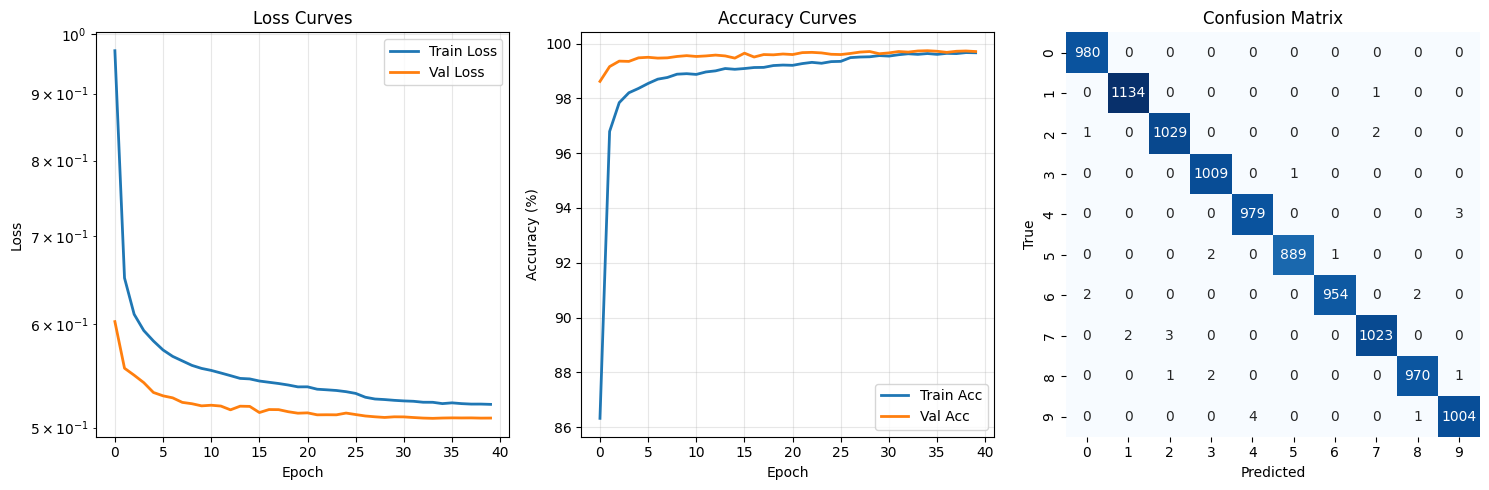


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9969    1.0000    0.9985       980
           1     0.9982    0.9991    0.9987      1135
           2     0.9961    0.9971    0.9966      1032
           3     0.9961    0.9990    0.9975      1010
           4     0.9959    0.9969    0.9964       982
           5     0.9989    0.9966    0.9978       892
           6     0.9990    0.9958    0.9974       958
           7     0.9971    0.9951    0.9961      1028
           8     0.9969    0.9959    0.9964       974
           9     0.9960    0.9950    0.9955      1009

    accuracy                         0.9971     10000
   macro avg     0.9971    0.9971    0.9971     10000
weighted avg     0.9971    0.9971    0.9971     10000


SAMPLE PREDICTIONS


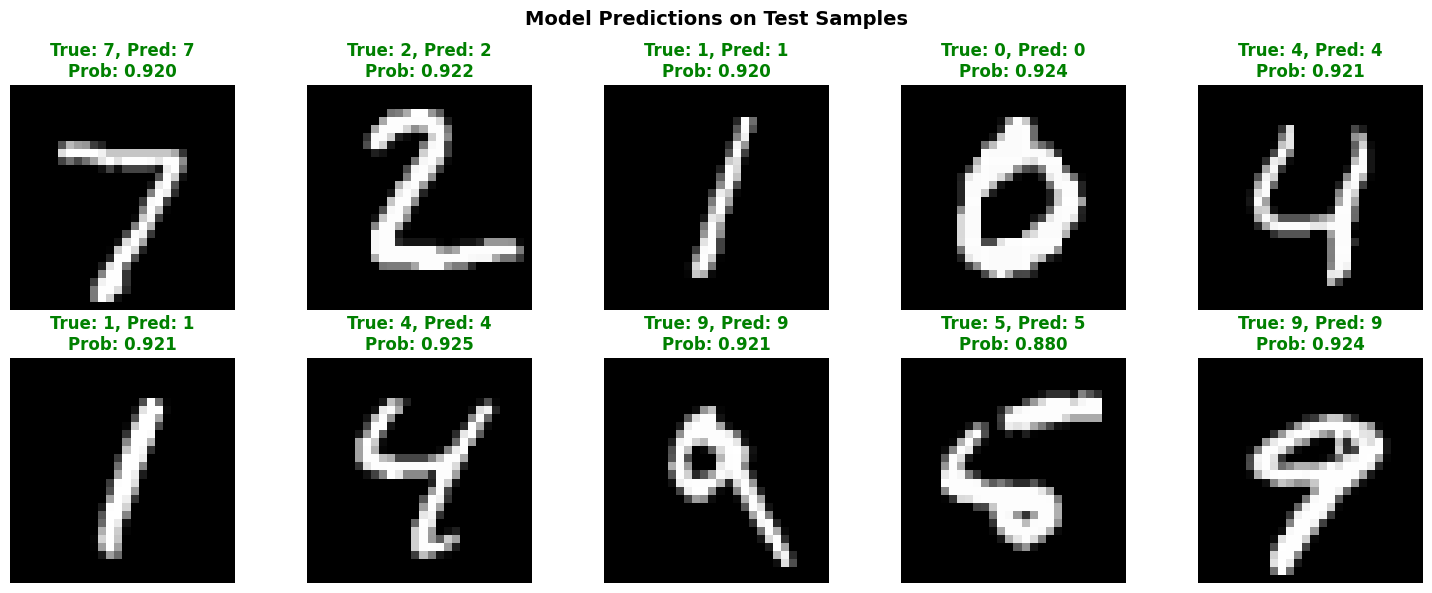


Best validation accuracy achieved: 99.74%
Expected log loss: ~4.6052


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Улучшенная аугментация данных
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST стандартные значения
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Загрузка данных
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Улучшенная архитектура
class SuperNet(nn.Module):
    def __init__(self, dropout_rate=0.3):  # Исправлено: __init__ вместо init
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate/2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(dropout_rate/2),

            nn.Linear(64, 10)
        )

        # Инициализация весов
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Функция обучения
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()  # Исправленный отступ
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    accuracy = 100. * correct / total  # Исправленный отступ
    avg_loss = train_loss / len(train_loader)
    return avg_loss, accuracy

# Функция валидации
def validate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    return avg_loss, accuracy

# Основной цикл обучения
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SuperNet(dropout_rate=0.3).to(device)  # Исправлено: SuperNet()

    # Оптимизатор с разными learning rates для разных слоев
    conv_params = list(model.conv_layers.parameters())
    fc_params = list(model.fc_layers.parameters())

    optimizer = optim.AdamW([
        {'params': conv_params, 'lr': 0.001},
        {'params': fc_params, 'lr': 0.002}
    ], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing

    # Learning rate schedulers
    scheduler1 = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    scheduler2 = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

    epochs = 40
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_acc = 0
    patience_counter = 0
    patience = 8

    for epoch in range(1, epochs + 1):
        print(f'\nEpoch {epoch}/{epochs}')
        print('-' * 60)

        train_loss, train_acc = train_epoch(model, device, trainloader, optimizer, criterion, epoch)
        val_loss, val_acc = validate(model, device, testloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Сохранение лучшей модели
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
            patience_counter = 0
            print(f'Model saved! New best accuracy: {val_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'No improvement for {patience_counter} epochs')

        # Ранняя остановка
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

        # Обновление learning rate
        scheduler1.step(val_loss)
        if epoch >= 20:
            scheduler2.step()

    # Визуализация результатов
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Acc', linewidth=2)
    plt.plot(val_accs, label='Val Acc', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confusion matrix
    plt.subplot(1, 3, 3)
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in testloader:
            data = data.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.numpy())

    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Отчет по классификации
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_targets, all_preds, digits=4))

    # Проверка на несколько примеров
    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS")
    print("="*60)

    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    with torch.no_grad():
        for i in range(10):
            img, label = testset[i]
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
            prob = F.softmax(output, dim=1)[0][pred].item()

            ax = axes[i//5, i%5]
            ax.imshow(img.squeeze(), cmap='gray')

            color = 'green' if pred == label else 'red'
            ax.set_title(f'True: {label}, Pred: {pred}\nProb: {prob:.3f}',
                        color=color, fontweight='bold')
            ax.axis('off')

    plt.suptitle('Model Predictions on Test Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return best_acc

if __name__ == '__main__':
    best_accuracy = main()
    print(f"\nBest validation accuracy achieved: {best_accuracy:.2f}%")
    print(f"Expected log loss: ~{np.log(1/0.01):.4f}")